In this notebook we will apply LDA again, but we will remove any project descriptions that were detected as non-english.

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from ast import literal_eval

from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation

from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [42]:
# metrics for each class + weighted average (- bad impact)
# micro f1 = accuracy
def print_metrics(cls, X_test, y_test):
    sns.heatmap(confusion_matrix(y_test, cls.predict(X_test)), annot=True, fmt='g', annot_kws={"size": 16})
    print('accuracy: ',metrics.accuracy_score(y_test, cls.predict(X_test)))
    print()
    print(metrics.classification_report(y_test, cls.predict(X_test)))
    print('macro precision: ',metrics.precision_score(y_test, cls.predict(X_test), average='macro'))
    print('micro precision: ',metrics.precision_score(y_test, cls.predict(X_test), average='micro'))
    print()
    print('micro recall: ',metrics.recall_score(y_test, cls.predict(X_test), average='micro'))
    print('macro recall: ',metrics.recall_score(y_test, cls.predict(X_test), average='macro'))
    print()
    print('micro f1: ',metrics.f1_score(y_test, cls.predict(X_test), average='micro'))
    print('macro f1: ',metrics.f1_score(y_test, cls.predict(X_test), average='macro'))
    plt.show()

In [44]:
df = pd.read_csv('data/split/nlp/train_tokens.csv', index_col=0, encoding='latin1')
df_test = pd.read_csv('data/split/nlp/test_tokens.csv', index_col=0, encoding='latin1')
df_cv = pd.read_csv('data/split/nlp/cv_tokens.csv', index_col=0, encoding='latin1')

In [45]:
# tokens column is treated as string
df['tokens'] = df['tokens'].apply(lambda x: literal_eval(x))
df_test['tokens'] = df_test['tokens'].apply(lambda x: literal_eval(x))
df_cv['tokens'] = df_cv['tokens'].apply(lambda x: literal_eval(x))

In [46]:
df.tokens[0][0]

'taken'

In [47]:
print(len(df), len(df_test), len(df_cv))

18296 6099 6100


In [48]:
df = df[(df['lang_1'] == 'en') & (df['lang_2'] == 'en')]
df_test = df_test[(df_test['lang_1'] == 'en') & (df_test['lang_2'] == 'en')]
df_cv = df_cv[(df_cv['lang_1'] == 'en') & (df_cv['lang_2'] == 'en')]

In [49]:
print(len(df), len(df_test), len(df_cv))

16927 5653 5605


In [14]:
tokens_len = df['tokens'].apply(lambda x: len(x))

In [15]:
tokens_len.describe()

count    16927.000000
mean       319.168784
std        321.578732
min          1.000000
25%        109.000000
50%        216.000000
75%        415.000000
max       3990.000000
Name: tokens, dtype: float64

In [16]:
tokens_len.sort_values(ascending=False).head()

6942     3990
15534    3990
10232    3539
3867     3314
12993    2960
Name: tokens, dtype: int64

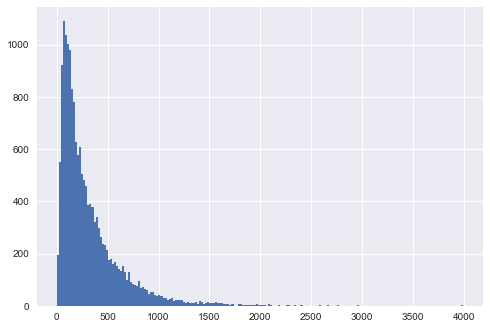

In [17]:
tokens_len.hist(bins=200)

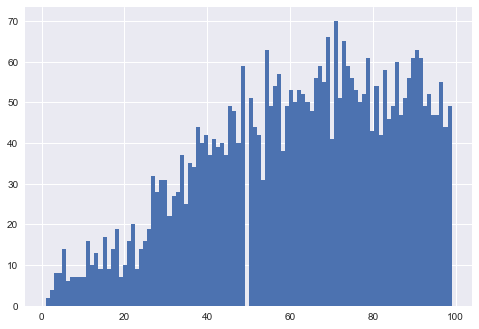

In [18]:
tokens_len[tokens_len<100].hist(bins=100)

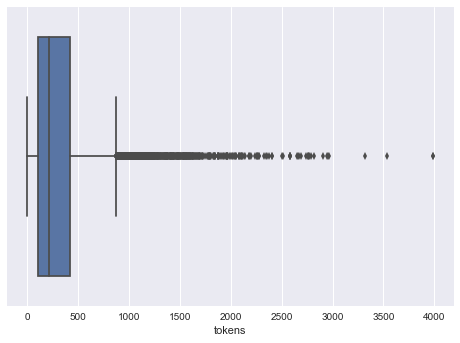

In [19]:
sns.boxplot(tokens_len)

### Document frequency

In [20]:
doc_freq = defaultdict(int)

for tokens in df['tokens']:
    for unique_token in set(tokens):
        doc_freq[unique_token] += 1

In [21]:
# number of unique tokens in all documents
len(doc_freq)

186373

In [22]:
doc_freq_series = pd.Series(doc_freq)

In [23]:
doc_freq_series.sort_values(ascending=False)

one             9460
make            9246
help            9134
time            9037
also            8618
year            8530
need            8425
project         8402
like            7994
get             7984
new             7864
work            7749
u               7737
first           7535
want            7111
people          6838
world           6662
way             6344
life            6343
many            6284
see             6197
well            6194
would           6187
go              6089
goal            5986
support         5941
take            5903
kickstarter     5875
come            5749
love            5574
                ... 
kharagpur          1
khalezin           1
khalid             1
khalik             1
tagvial            1
khalils            1
khaluagrappa       1
tagthe             1
khanacademy        1
khangtsen          1
khanh              1
khanom             1
khao               1
khar               1
kharit             1
khin               1
kharkov      

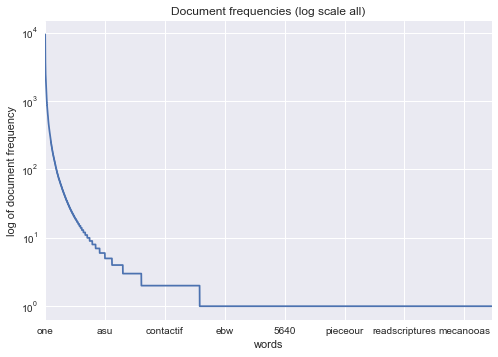

In [24]:
doc_freq_series.sort_values(ascending=False).plot()
plt.yscale('log')
plt.title('Document frequencies (log scale all)')
plt.xlabel('words')
plt.ylabel('log of document frequency')

In [25]:
(doc_freq_series / len(df)).describe()

count    186373.000000
mean          0.001085
std           0.009948
min           0.000059
25%           0.000059
50%           0.000059
75%           0.000118
max           0.558870
dtype: float64

(0, 10000)

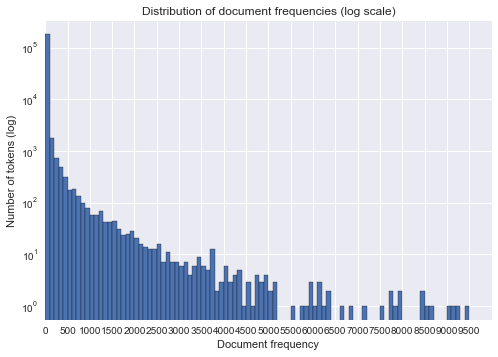

In [26]:
doc_freq_series.plot(kind='hist', bins=np.arange(0, 10000, 100), ec='black')
plt.yscale('log')
plt.title('Distribution of document frequencies (log scale)')
plt.xlabel('Document frequency')
plt.ylabel('Number of tokens (log)')
plt.xticks(np.arange(0, 10000, 500))
plt.xlim(0, 10000)

In [27]:
# how many tokens are in the interval
len(doc_freq_series[doc_freq_series > 1])

64470

# LDA

In [28]:
# source: http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

#### Calculate tf

We will not store tf in datasets.

In [32]:
tf_vectorizer = CountVectorizer(preprocessor=' '.join)
tf = tf_vectorizer.fit_transform(df['tokens'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [33]:
len(tf_feature_names)

185352

In [50]:
# test set
tf_test = tf_vectorizer.transform(df_test['tokens'])

In [51]:
# validation set
tf_cv = tf_vectorizer.transform(df_cv['tokens'])

#### Use LDA

In [59]:
lda = LatentDirichletAllocation(random_state=64, n_jobs=-1, n_components=50)

In [60]:
lda.fit(tf)

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=50, n_jobs=-1,
             n_topics=None, perp_tol=0.1, random_state=64,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [61]:
print_top_words(lda, tf_feature_names, 10)

Topic #0: vr hair blade reality drill brush winding dexter commander bernie
Topic #1: book reward print page one art comic story kickstarter get
Topic #2: che calamita qutiger mu mirrocool folio emi hitter batter sergio
Topic #3: art artist dance performance new work space theatre york theater
Topic #4: flavor sauce hot sweet sugar pepper beef salt meat blend
Topic #5: pendant playa spindle boson irregular electron lobby hammock silva physicist
Topic #6: hop hip pyramid joey summit na nikon pinhole atlas fisher
Topic #7: neural eeg licence openbci nurugo jib k2 sla forthe clarence
Topic #8: chicken bacon rice tomato potato fry garlic homemade nacho pac
Topic #9: zine sophie roberto cpc zeeq tablethookz zines pike condensed scalpel
Topic #10: delta marc slave octopus liedtke moonlight universo jorge lopez omar
Topic #11: fractal stax compass academia ferrofluid archaeologist abortion picasso whisky deception
Topic #12: shervin robox cinera vignelli airjamz rumi nuprime fuzzbuquet debra 

In [62]:
features = pd.DataFrame(lda.transform(tf))

In [63]:
features_test = pd.DataFrame(lda.transform(tf_test))

In [64]:
features_cv = pd.DataFrame(lda.transform(tf_cv))

#### Predict class using only LDA topics (all projects - not only 25% of them)

In [65]:
labels = df['class']
labels_test = df_test['class']

In [66]:
cls = GradientBoostingClassifier(random_state=64)

In [67]:
cls.fit(features, labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.588468127843

             precision    recall  f1-score   support

          1       0.63      0.85      0.72      7021
          2       0.92      0.05      0.10      2217
          3       0.51      0.44      0.47      3833
          4       0.55      0.57      0.56      3856

avg / total       0.62      0.59      0.55     16927

macro precision:  0.651421718632
micro precision:  0.588468127843

micro recall:  0.588468127843
macro recall:  0.477906697019

micro f1:  0.588468127843
macro f1:  0.46383187851


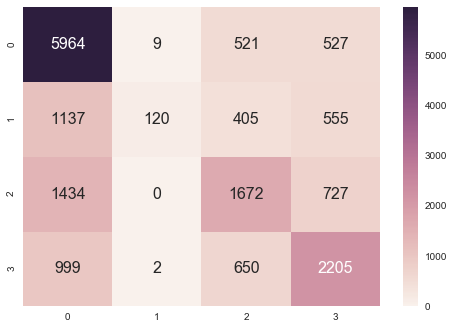

In [68]:
print_metrics(cls, features, labels)

accuracy:  0.555634176543

             precision    recall  f1-score   support

          1       0.61      0.84      0.70      2387
          2       0.53      0.01      0.03       718
          3       0.44      0.38      0.41      1259
          4       0.52      0.50      0.51      1289

avg / total       0.54      0.56      0.51      5653

macro precision:  0.523870477694
micro precision:  0.555634176543

micro recall:  0.555634176543
macro recall:  0.433970478886

micro f1:  0.555634176543
macro f1:  0.412741696146


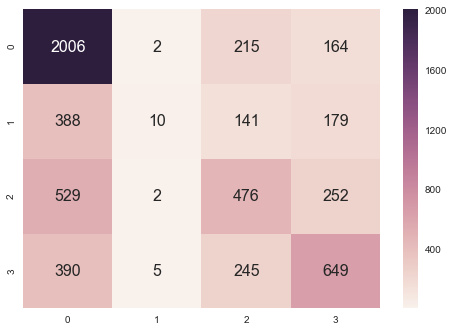

In [69]:
print_metrics(cls, features_test, labels_test)

In [57]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(features.columns)), features.columns, cls.feature_importances_):
    importances.loc[i, 'feature'] = name
    importances.loc[i, 'importance'] = importance

In [58]:
importances[importances['importance'] > 0].sort_values(by='importance', ascending=False)

,feature,importance
3,3.0,0.145754
6,6.0,0.127132
0,0.0,0.114460
5,5.0,0.098987
4,4.0,0.098514
9,9.0,0.092390
1,1.0,0.085158
8,8.0,0.084216
7,7.0,0.078726
2,2.0,0.074663


# Summary

Unfortunately, we can see that topics still contain non-english words. Even after we included only descriptions that were detected as english using both first and last 100 characters. Therefore we have to admit that language detection process was unsuccessful.